# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [1]:
import numpy as np
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from torchsummary import summary
import random
from __future__ import print_function
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
import torchvision
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
BATCH_SIZE = 128
IMAGE_SHAPE = (64, 64)
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 100

# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR =  '/content/drive/MyDrive/DL/A4/Data'

###Load the dataset

In [19]:
###You can either use the dataloader or load all of the data using one of the helper functions

data_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.CenterCrop((64, 64)),
    #transform.transpose(x, 0, 1),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
t_dataset = dataset.ImageFolder(root=BASE_DIR, transform=data_transform)
dataloader = torch.utils.data.DataLoader(dataset=t_dataset, batch_size=BATCH_SIZE, shuffle=True)
device = torch.device("cuda")

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

### Implementing the Discriminator of the DCGAN
The architecture of the discriminator is provided in an image with this notebook. You can use that or use a different one.

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: use_bias = False
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [13]:
# Generator Code
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 4, 1, padding=0, bias=False),

            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [14]:
#initialize and cast to device
d1_net = Discriminator()
d1_net =d1_net.to(device)


In [ ]:
#print summary
summary(d1_net, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

### Implementing the Generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator's architecture has been provided as well.
<br>

**Some important points:**
- Pass in use_bias=False, padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the diagram.

Implement the generator in the cell below

In [15]:
# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
#initialize and cast to device
g1_net = Generator()
g1_net = g1_net.to(device)

#print summary
summary(g1_net, (100, 64, 64))
print(g1_net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [-1, 512, 67, 67]         819,200
       BatchNorm2d-2          [-1, 512, 67, 67]           1,024
              ReLU-3          [-1, 512, 67, 67]               0
   ConvTranspose2d-4        [-1, 256, 134, 134]       2,097,152
       BatchNorm2d-5        [-1, 256, 134, 134]             512
              ReLU-6        [-1, 256, 134, 134]               0
   ConvTranspose2d-7        [-1, 128, 268, 268]         524,288
       BatchNorm2d-8        [-1, 128, 268, 268]             256
              ReLU-9        [-1, 128, 268, 268]               0
  ConvTranspose2d-10         [-1, 64, 536, 536]         131,072
      BatchNorm2d-11         [-1, 64, 536, 536]             128
             ReLU-12         [-1, 64, 536, 536]               0
  ConvTranspose2d-13        [-1, 3, 1072, 1072]           3,072
             Tanh-14        [-1, 3, 107

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [17]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
lr = 0.0002
beta1 = 0.5

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup optimizers for both G and D

optimizerD = torch.optim.Adam(d1_net.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(g1_net.parameters(), lr=lr, betas=(beta1, 0.999))

### Training the GAN
We will train a DCGAN to generate fake Apple emojis.

Write your training loop in the cell bellow.

In [20]:
img_list = []
G_losses = []
D_losses = []
x = 0
Z =100

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    for i, real_img in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        d1_net.zero_grad()
        img = real_img[0].to(device)
        label = torch.full((img.size(0),), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        d = d1_net(img).view(-1)
        # Calculate loss on all-real batch
        Dis_real_l = criterion(d, label)
        Dis_real_l.backward()
        
        # Generate batch of latent vectors
        noise = torch.randn(img.size(0), Z, 1, 1, device=device)
        f_image = g1_net(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        d = d1_net(f_image.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        Dis_fake_l = criterion(d, label)
        Dis_fake_l.backward()
        Dis_loss = Dis_real_l + Dis_fake_l
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        g1_net.zero_grad()
        label.fill_(real_label)  
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = d1_net(f_image).view(-1)
        # Calculate G's loss based on this output
        Gen_loss = criterion(output, label)
        Gen_loss.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, EPOCHS,
                     Dis_loss.item(), Gen_loss.item()))

        # Save Losses for plotting later
        G_losses.append(Gen_loss.item())
        D_losses.append(Dis_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (x % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = g1_net(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=1, normalize=True))

        x += 1

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[1/100]	Loss_D: 1.4182	Loss_G: 3.3484
[2/100]	Loss_D: 0.2788	Loss_G: 7.1025
[3/100]	Loss_D: 0.1264	Loss_G: 8.1450
[4/100]	Loss_D: 0.0291	Loss_G: 7.8021
[5/100]	Loss_D: 0.0235	Loss_G: 8.7333
[6/100]	Loss_D: 0.0174	Loss_G: 17.5441
[7/100]	Loss_D: 0.4510	Loss_G: 16.9636
[8/100]	Loss_D: 4.9947	Loss_G: 15.8434
[9/100]	Loss_D: 0.0075	Loss_G: 6.6809
[10/100]	Loss_D: 0.0150	Loss_G: 12.9410
[11/100]	Loss_D: 0.1314	Loss_G: 13.2033
[12/100]	Loss_D: 0.7891	Loss_G: 12.7809
[13/100]	Loss_D: 0.2439	Loss_G: 6.4312
[14/100]	Loss_D: 0.2768	Loss_G: 6.7728
[15/100]	Loss_D: 0.3170	Loss_G: 5.3548
[16/100]	Loss_D: 0.3243	Loss_G: 5.3106
[17/100]	Loss_D: 0.3245	Loss_G: 5.5345
[18/100]	Loss_D: 0.3615	Loss_G: 4.4308
[19/100]	Loss_D: 2.1206	Loss_G: 6.7019
[20/100]	Loss_D: 0.5906	Loss_G: 5.4728
[21/100]	Loss_D: 0.4289	Loss_G: 3.0084
[22/100]	Loss_D: 0.3295	Loss_G: 4.8172
[23/100]	Loss_D: 0.4686	Loss_G: 7.5424
[24/100]	Loss_D: 0.4961	Loss_G: 5.8523
[25/100]	Loss_D: 0.5734	Loss_G: 6.7393
[26/100]	Loss_D: 0.2911	Loss

### Generating Samples and Analysis

- Plot your discriminator and generator losses.
- Generate random 5 noise samples and their corresponding fake images.

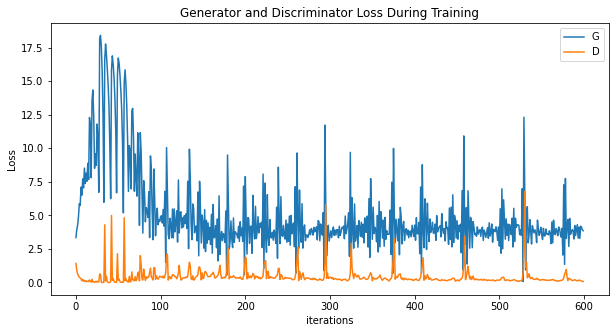

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


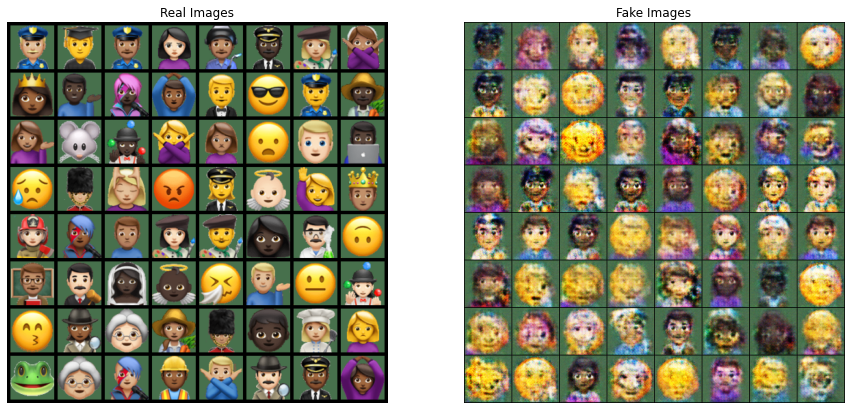

In [22]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## PART 2: Stabilizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (https://pytorch.org/docs/stable/nn.init.html)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [ ]:
#initialize and cast to device
# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, 4, 1, padding=0, bias=False),
            #nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
device = torch.device("cuda")

In [ ]:
d2_net = Discriminator()
d2_net = d2_net.to(device)

In [ ]:
summary(d2_net, (3, 64, 64))
print(d2_net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [ ]:
# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

#initialize and cast to device
g2_net = Generator()
g2_net = g2_net.to(device)

#print summary
summary(g2_net, (100, 64, 64))
print(g2_net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [-1, 512, 67, 67]         819,200
       BatchNorm2d-2          [-1, 512, 67, 67]           1,024
         LeakyReLU-3          [-1, 512, 67, 67]               0
   ConvTranspose2d-4        [-1, 256, 134, 134]       2,097,152
       BatchNorm2d-5        [-1, 256, 134, 134]             512
         LeakyReLU-6        [-1, 256, 134, 134]               0
   ConvTranspose2d-7        [-1, 128, 268, 268]         524,288
       BatchNorm2d-8        [-1, 128, 268, 268]             256
         LeakyReLU-9        [-1, 128, 268, 268]               0
  ConvTranspose2d-10         [-1, 64, 536, 536]         131,072
      BatchNorm2d-11         [-1, 64, 536, 536]             128
        LeakyReLU-12         [-1, 64, 536, 536]               0
  ConvTranspose2d-13        [-1, 3, 1072, 1072]           3,072
             Tanh-14        [-1, 3, 107

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    #torch.nn.init.normal_(m.weight, 0.0, 0.02)
    # mean=0 and std = 0.02
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias) 

d2_net.apply(weights_init)
g2_net.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding

### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [ ]:
def normalize(images):
    images = images.astype('float32')
    images = (images - 127.5) / 127.5
    return images

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample from a Gaussian distribution.

In [ ]:
def sample_noise(BATCH_SIZE, NOISE_DIM):
    return torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1, device=device)

### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [ ]:
def smooth_real_labels(y):
    y = y - 0.3
    y += np.random.random(y.shape) * 0.5
    return y

#### Fake Label Smoothing

In [ ]:
def smooth_fake_labels(y):
    y = y.astype('float32')
    y = y + np.random.random(y.shape) * 0.2
    return y

We will make use of these functions later in our training loop.

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

In [ ]:
#flip labels
def flip_labels(real, fake):
  real, fake = fake, real
  return real, fake

In [ ]:
loss = nn.BCELoss()

#loss =nn.CrossEntropyLoss()
BATCH_SIZE = 64
IMAGE_SHAPE = (64, 64)
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 80

BASE_DIR =  '/content/drive/MyDrive/DL/A4/Data'
data_transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.CenterCrop((64, 64)),
    #transform.transpose(x, 0, 1),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
t_dataset = dataset.ImageFolder(root=BASE_DIR, transform=data_transform)
dataloader = torch.utils.data.DataLoader(dataset=t_dataset, batch_size=BATCH_SIZE, shuffle=True)
device = torch.device("cuda")

lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(d2_net.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(g2_net.parameters(), lr=lr, betas=(beta1, 0.999))


### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of. Plot the losses and final images just as in the previous part.

In [ ]:
D_losses = []
G_losses = []
img_list = []
Z =100
x = 0
for epoch in range(1, EPOCHS+1): 
    Gen_loss = []
    Dis_loss = []
   
    for i, (real_img, _) in enumerate(dataloader):
        optimizerD.zero_grad()
        real_img = real_img.to(device)

        #normalization badly effects the model
        #real_img = real_img.cpu().detach().numpy()
        #real_img = normalize(real_img)
        #real_img = torch.from_numpy(real_img).to(device)

        real_label = Variable(torch.ones(real_img.size(0)).to(device))
        real_label = real_label.cpu().detach().numpy()
        real_label = smooth_real_labels(real_label)
        real_label = torch.from_numpy(real_label).to(device)
        
        fake_label = Variable(torch.zeros(real_img.size(0)).to(device))
        #fake_label = fake_label.cpu().detach().numpy()
        #fake_label = smooth_fake_labels(fake_label)
        #fake_label = torch.from_numpy(fake_label).to(device)

        #if (x == 50):
          #real_label, fake_label = flip_labels(real_label, fake_label)
        
        o = d2_net(real_img)
        d = d2_net(real_img).view(-1)
        D_real_loss = loss(d, real_label.float())
        D_real_loss.backward()
    
        noise_vector = torch.randn(real_img.size(0), Z, 1, 1, dtype=torch.float, device=device)  
        noise_vector = noise_vector.to(device)
        generated_image = g2_net(noise_vector)
        generated_image =generated_image.float()
        output = d2_net(generated_image.detach()).view(-1)
        output = output.to(device)
        D_fake_loss = loss(output.float(), fake_label.float())
    
        # train with fake
        D_fake_loss.backward()
        D_t_loss = D_real_loss + D_fake_loss
        Dis_loss.append(D_t_loss)

        optimizerD.step()
        optimizerG.zero_grad()
        G_loss = loss(d2_net(generated_image).view(-1), real_label.float())
        Gen_loss.append(G_loss)

        G_loss.backward()
        optimizerG.step()

        if (x % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = g2_net(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        x += 1
    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), EPOCHS, torch.mean(torch.FloatTensor(Dis_loss)),\
             torch.mean(torch.FloatTensor(Gen_loss))))
    
    D_losses.append(torch.mean(torch.FloatTensor(Dis_loss)))
    G_losses.append(torch.mean(torch.FloatTensor(Gen_loss)))
    torch.save(g2_net.state_dict(), '/content/drive/MyDrive/DL/A4/generator_epoch_%d.pth' % (epoch))
    torch.save(d2_net.state_dict(), '/content/drive/MyDrive/DL/A4/discriminator_epoch_%d.pth' % (epoch))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: [1/80]: D_loss: 0.705, G_loss: 6.235
Epoch: [2/80]: D_loss: 0.696, G_loss: 9.149
Epoch: [3/80]: D_loss: 0.459, G_loss: 7.590
Epoch: [4/80]: D_loss: 0.541, G_loss: 9.923
Epoch: [5/80]: D_loss: 0.447, G_loss: 8.560
Epoch: [6/80]: D_loss: 0.497, G_loss: 8.660
Epoch: [7/80]: D_loss: 0.678, G_loss: 7.638
Epoch: [8/80]: D_loss: 0.824, G_loss: 7.253
Epoch: [9/80]: D_loss: 0.443, G_loss: 5.515
Epoch: [10/80]: D_loss: 0.631, G_loss: 6.037
Epoch: [11/80]: D_loss: 0.423, G_loss: 5.237
Epoch: [12/80]: D_loss: 0.434, G_loss: 5.628
Epoch: [13/80]: D_loss: 0.320, G_loss: 5.211
Epoch: [14/80]: D_loss: 0.900, G_loss: 6.072
Epoch: [15/80]: D_loss: 0.442, G_loss: 4.658
Epoch: [16/80]: D_loss: 0.377, G_loss: 4.453
Epoch: [17/80]: D_loss: 0.364, G_loss: 5.150
Epoch: [18/80]: D_loss: 0.479, G_loss: 5.715
Epoch: [19/80]: D_loss: 0.329, G_loss: 4.804
Epoch: [20/80]: D_loss: 1.039, G_loss: 5.445
Epoch: [21/80]: D_loss: 0.379, G_loss: 4.478
Epoch: [22/80]: D_loss: 0.363, G_loss: 4.567
Epoch: [23/80]: D_l

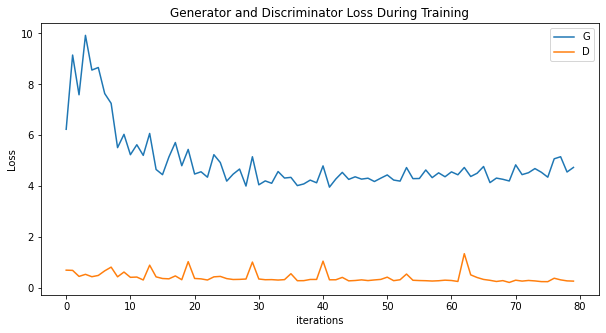

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


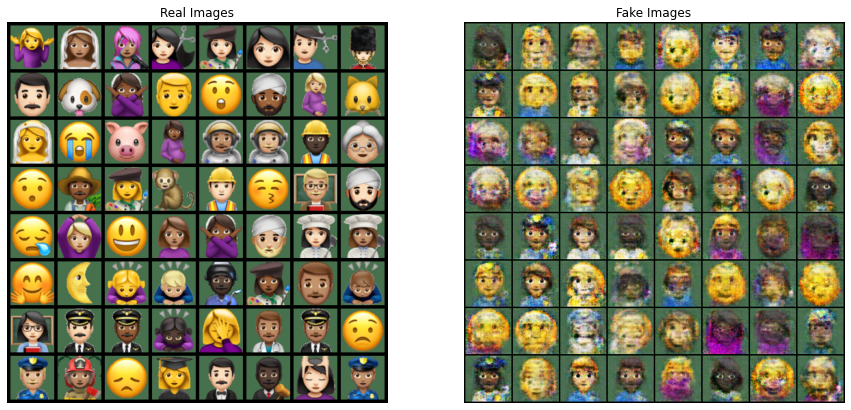

In [ ]:
#print(img_list)
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

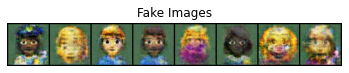

In [ ]:
#plt.subplot(1,2,1)
plt.title("Fake Images")
l = np.transpose(img_list[-1],(1,2,0))
plt.imshow(l[64*7+14:64*9+4][64])
plt.axis("off")
plt.show()

###Analysis

The methods which worked for you and analysis:

**Best results:**
Model in task 2 gives slightly better fake images as compare to model in task 1.




**Methods used in Task2:**
I used the following methods to upgrade training in task 2: 
* LeakyReLu in BOTH the generator and discriminator
* Gaussian Weight initialization
* Adam optimizer(it gives good results)
* Normalization (by doing normalization fake images get distorted, so I have removed this from the model training)
* Real Label Smoothing
* Fake Label smoothing
* Label flipping (removed this as it causes images to distor)

## PART 3: Interpolation

You have to do this part in Keras.

Model weight is provided. Dataset link: https://drive.google.com/drive/folders/1tg-Ur7d4vk1T8Bn0pPpUSQPxlPGBlGfv

In [ ]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
import glob
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# data folder path in colab runtime enviroment
DATA_FOLDER = '/content/drive/MyDrive/DL/A4/thumbnails128x128/'

# fetching all the filenmaes to read them later in generator
filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.png')))
#filenames = np.array(glob.glob('/content/drive/MyDrive/DL/A4/thumbnails128x128/*/*.png'))


# total images in directory
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 70000


In [ ]:
INPUT_DIM = (128,128,3) 
BATCH_SIZE = 128       
Z_DIM = 100             

#data generator
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, target_size = INPUT_DIM[:2], batch_size = BATCH_SIZE, shuffle = True)
print(len(data_flow))

Found 70000 images belonging to 70 classes.
547


*  Model weights are provided to you, use that model and interpolate 5 images.
*  If you want to train the model from scratch it's up to you.



In [ ]:
def define_generator():
	model = Sequential()
	n_nodes = 128 * 4 * 4
	model.add(Dense(n_nodes, input_dim=Z_DIM))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

In [ ]:
#initialize the model here and generate some sample images


In [ ]:
g3_net = define_generator()
g3_net.load_weights('/content/drive/MyDrive/DL/A4/generator.h5')

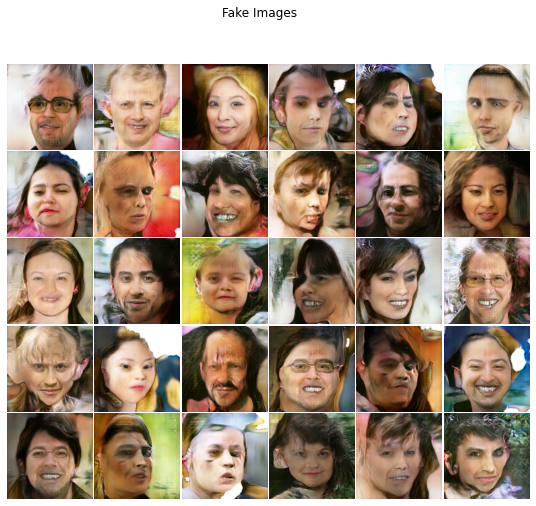

In [ ]:
Z = 100
n = 30
noise = np.reshape(np.random.randn(Z * n),(n, Z))
fake_img = g3_net.predict(noise)
img_grid = ImageGrid(plt.figure(figsize=(10., 8), ), 111, nrows_ncols=(5, 6))

for ax, im in zip(img_grid, fake_img):
    #im = im/np.amax(im)
    im = np.clip(im, 0, 1)
    ax.imshow(im)
    ax.axis("off")
    
plt.suptitle('Fake Images')
plt.show()


You can play around with the images for example:
	
1.  *Glasses on Woman - Neutral Woman + Neutral Man = Glasses on Man*
2.  *Smile on Woman - Neutral Woman + Neutral Man = smile on Man*

Create 10 different scenarios and display

In [ ]:
#interpolate\
def avg_point(points, ix):
	return np.mean(points[ix], axis=0)
#storing indexes, 1, 24 belong to smiling man 
index_smil_m = [1, 24]
index_neut_m = [1, 13, 18, 20]
index_smil_w = [12, 16, 24]
index_neut_w = [2, 6, 11, 19, 27]
index_glasses_m = [0, 17, 21]

noise = np.reshape(np.random.randn(Z * n),(n, Z))
smil_woman = avg_point(noise, index_smil_w)
smil_man = avg_point(noise, index_smil_m)
glasses_on_man = avg_point(noise, index_glasses_m)
neut_woman = avg_point(noise, index_neut_w)
neut_man = avg_point(noise, index_neut_m)

# 10 different scenarios
all_scenarios = []
all_scenarios.append(smil_man - neut_woman + neut_man)
all_scenarios.append(neut_man - neut_woman + glasses_on_man)
all_scenarios.append(smil_woman - neut_woman + neut_man)
all_scenarios.append(neut_woman - neut_man + smil_man)
all_scenarios.append(glasses_on_man - smil_woman + neut_man)
all_scenarios.append(glasses_on_man - neut_man + smil_woman)
#all_scenarios.append(glasses_man - smiling_man + neutral_woman)
all_scenarios.append(glasses_on_man - neut_man + neut_woman)
all_scenarios.append(smil_woman - neut_man + smil_man)
all_scenarios.append(smil_man - neut_woman + smil_woman)
all_scenarios.append(neut_man - glasses_on_man + smil_man)

#### Display Results

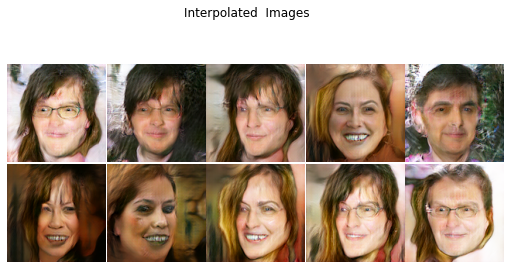

In [ ]:
images = []
for i in all_scenarios:
  images.append(g3_net.predict(np.expand_dims(i, 0))[0])
images = np.array(images)
img_grid = ImageGrid(plt.figure(figsize=(10., 8), ), 211, nrows_ncols=(2, 5))

for ax, im in zip(img_grid, images):
    #im = im/np.amax(im)
    im = np.clip(im, 0, 1)
    ax.imshow(im)
    ax.axis("off")
    
plt.suptitle('Interpolated  Images')
plt.show()